# Gaussian R-XOR and Gaussian XNOR Experiments: Streaming vs. Batch Forests

In [1]:
import numpy as np
import streaming_synf_functions as fn
from proglearn.sims import generate_gaussian_parity
from proglearn.forest import LifelongClassificationForest


Note: This notebook uses external functions stored in `streaming_synf_functions.py`

## Using the `update_task` function for streaming data

Current standard implementations of decision forests operate in batch mode. In many real world applications, we are not provided with all data at once and therefore need to incrementally update as data arrives. For incrementally updating decision trees we can use the [scikit-learn-stream fork](https://github.com/PSSF23/scikit-learn-stream) with an added `partial_fit` function for incremental learning. Furthermore, for synergistic learning we can use the function `update_task`. When new data, $x$, arrives with labels, $y$, we can update task $t$ as follows:

`synf.update_task(x,y,task_id = t)`

## Synergistic Learning

The goal of synergistic learning is to improve performance on the current task as well as past and future tasks. This can be accomplished through ensembling independent representations, as is done in both Synergistic Forest implementations. 

The metric of learning efficiency, as described in Vogelstein et al. 2020, can be used to quantify a classifier's learning abilities. 

The **learning efficiency** of an algorithm $f$ for a given task $t$ with sample size $n$ is defined as 
$$\text{LE}^t_n(f):=\frac{\mathbb{E}[R^t(f(\mathbf{S}^t_n))]}{\mathbb{E}[R^t(f(\mathbf{S}_n))]}$$
If $\text{LE}^t_n(f) > 1$, $f$ has learned task $t$ with data $\mathbf{S}_n$

The **forward learning efficiency** of an algorithm $f$ for a given task $t$ with sample size $n$ is defined as 
$$\text{FLE}^t_n(f):=\frac{\mathbb{E}[R^t(f(\mathbf{S}^t_n))]}{\mathbb{E}[R^t(f(\mathbf{S}^{\leq t}_n))]}$$

If $\text{FLE}^t_n(f) > 1$, $f$ has leveraged data from past tasks to improve performance on task $t$

The **backward learning efficiency** of an algorithm $f$ for a given task $t$ with sample size $n$ is defined as 
$$\text{BLE}^t_n(f):=\frac{\mathbb{E}[R^t(f(\mathbf{S}^{\leq t}_n))]}{\mathbb{E}[R^t(f(\mathbf{S}_n))]}$$
If $\text{BLE}^t_n(f) > 1$, $f$ has leveraged data from future tasks to improve performance on previous tasks

An algorithm has **synergistically learned** if $\log\text{LE}^t_n(f) > 0$ for all $t \in \mathcal{T}$ 

Conversely, an algorithm has **catastrophically forgotten** if it has negatively learned for all tasks

## Running the Gaussian XOR experiments

In the following experiments, we compare Decision Forest, Stream Decision Forest, Synergistic Forest, and Stream Synergistic Forest on variations of the Gaussian XOR binary classification task. 

In [6]:
mc_rep = 100
fn.run_gaussian_experiments(mc_rep)

## Load results for plotting

In [ ]:
rxor_mean_errors, xnor_mean_errors, rxor_single_task_errors, xnor_single_task_errors = fn.load_data()
r_xor_transfer_efficiencies = fn.get_mean_te(rxor_mean_errors, rxor_single_task_errors)
xnor_transfer_efficiencies = fn.get_mean_te(xnor_mean_errors, xnor_single_task_errors)

## Gaussian XOR and Gaussian XNOR
Here we use Gaussian XOR and Gaussian XNOR simulated data. Gaussian XNOR has the same distribution as Gaussian XOR, but with the class labels rotated 90 degrees. Therefore, XNOR has the same optimal discriminant boundary as XOR. We first introduce 750 samples of XOR followed by 750 samples of XNOR. Data are introduced in batches of 25 samples at a time.

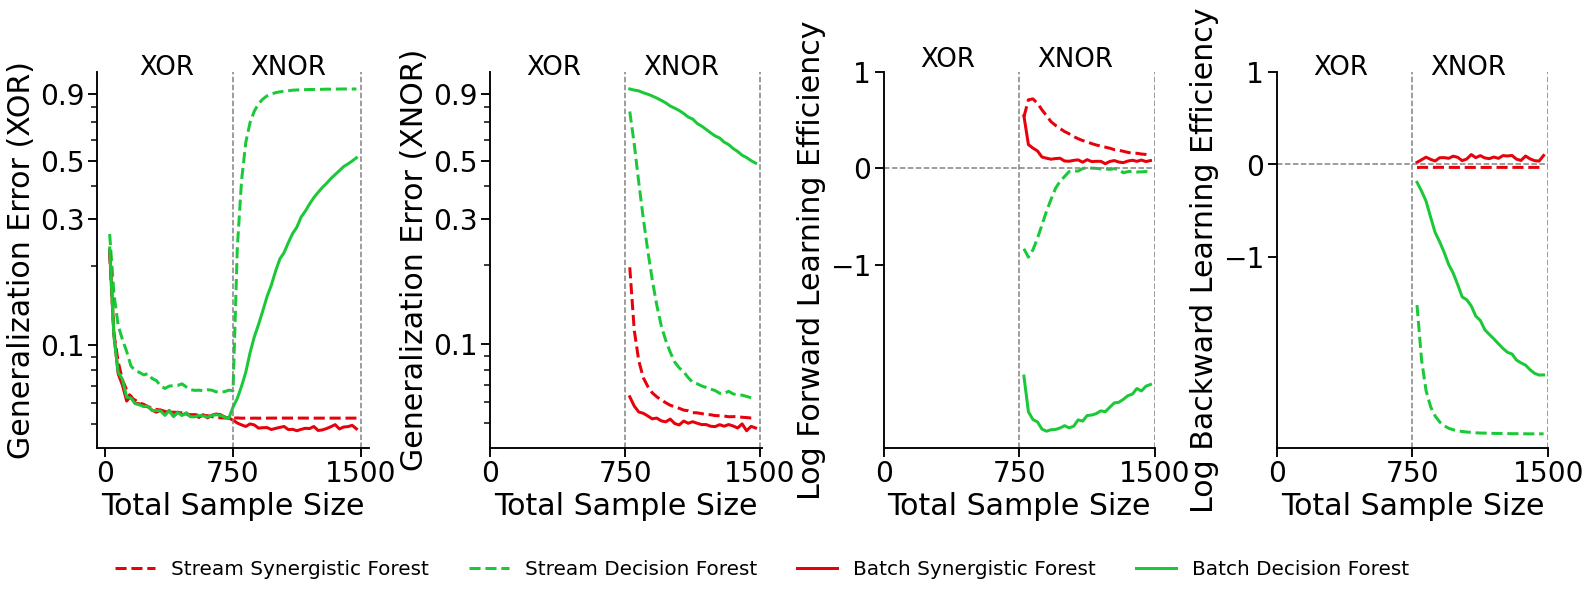

In [8]:
fn.plot_error(np.array(xnor_mean_errors), "XNOR", np.log(xnor_transfer_efficiencies))

## Gaussian XOR and Gaussian R-XOR
Here we use Gaussian XOR and Gaussian R-XOR simulated data. Gaussian R-XOR has the same distribution as Gaussian XOR, but with the class labels rotated 45 degrees. We introduce 750 samples of XOR data followed by 750 samples of R-XOR data. Data are introduced in batches of 25 samples at a time.

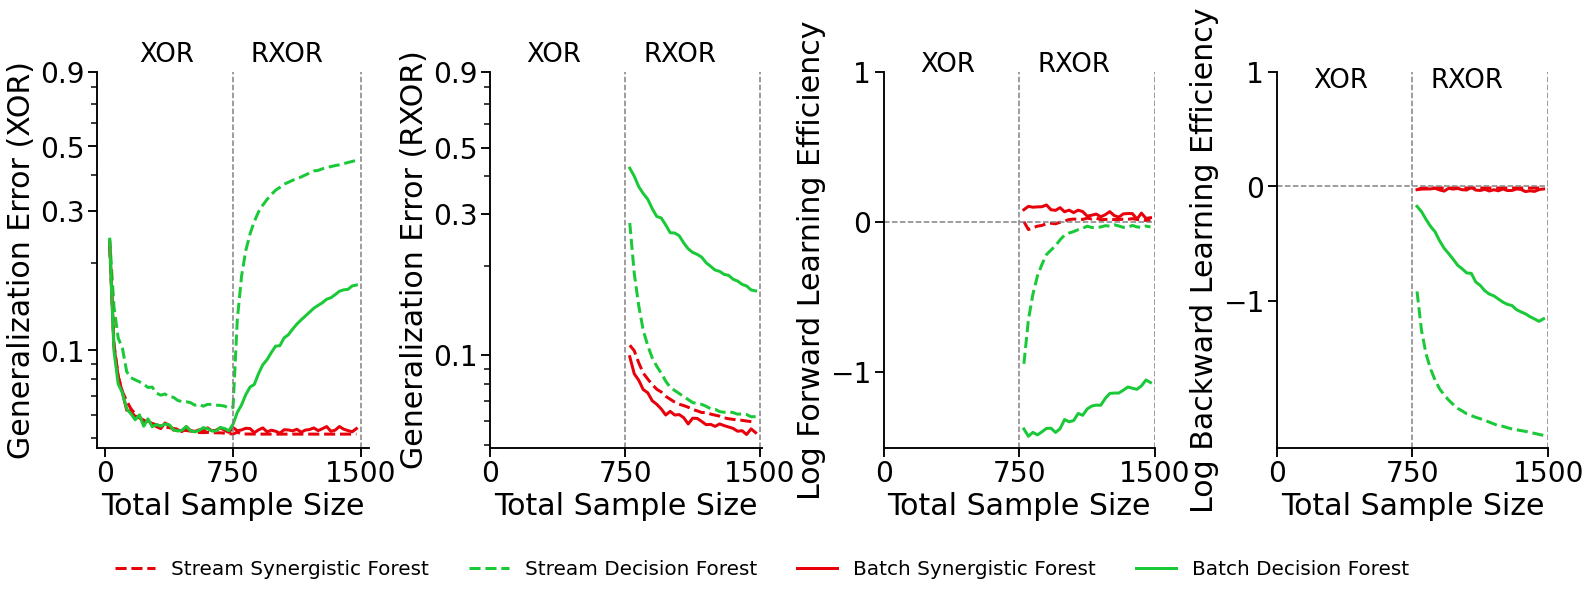

In [9]:
fn.plot_error(np.array(rxor_mean_errors), "RXOR", np.log(r_xor_transfer_efficiencies))

## Work in Progress Backwards Learning Efficiency and Angle of Rotation

Notes added below with the plots for jayanta and hao



In [2]:
angle_sweep = range(0, 90, 2)
task1_sample = 100
task2_sample = 100
mc_rep = 500  # reduce the number of repetitions for reduced runtime

In [ ]:
mean_te = fn.stream_ble_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)

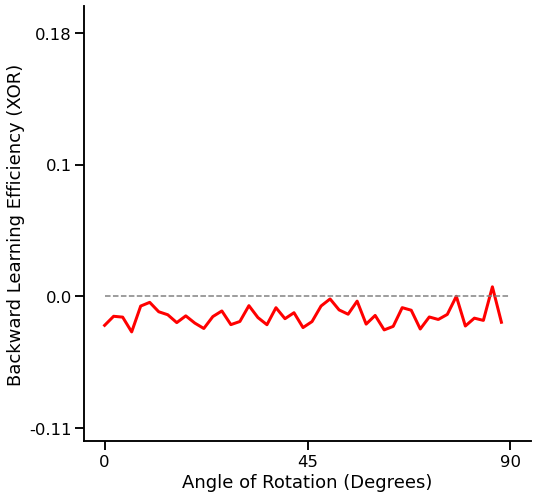

In [4]:
fn.plot_bte_v_angle(mean_te)

The above plot of BLE v Angle of rotation was run with the following parameters: 
- 100 XOR 
- 100 RXOR 
- 500 mc reps 
- 50 samples are added with `add_task` followed by another 50 samples with `update_task`

Its not showing the u shape as expected/not reverse transferring. I thought this was an issue with my experiment code but when i run the experiment without any task updating (ie. add 100 samples of xor with `add_task` and then 100 samples of RXOR with `add_task` i get a u shaped curve as expected). I ran this experiment with various parameters but the only somewhat interestng result is the following plot: 

Text(0.5, 1.0, '400 MC Reps- Streaming Synergistic Forest (update task w/ 50 samples at a time)')

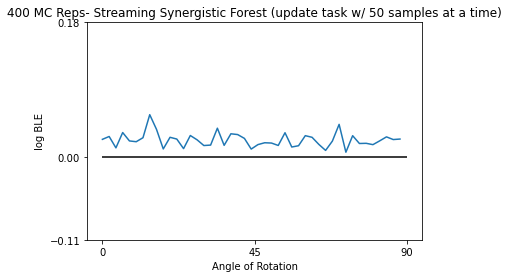

In [50]:
ble_v_angle_data = np.array(fn.load_result("ble_v_angle/stream_400rep.txt"))
plt.plot(range(0, 90, 2),np.log(ble_v_angle_data))
plt.hlines(0, 0, 90, color = "k")
plt.xticks([0,45,90])
plt.yticks([-0.11, 0 , 0.18])
plt.xlabel("Angle of Rotation")
plt.ylabel("log BLE")
plt.title("400 MC Reps- Streaming Synergistic Forest (update task w/ 50 samples at a time)")


Above again there is no u shape but log BLE is positive. Next, I wanted to see if streaming synf implementation was able to backwards transfer in any context so i re-ran the RXOR and XNOR experiments with 100 mc reps to get smoother plots. It showed backwards transfer before but i wasnt sure if this was a result of noise so i ran the experiments with more reps. These are shown above (first two plots in the notebook). Streaming synf was able to forward transfer in both experiments however was not able to backwards transfer whereas the regular synf implementation (without `update_task`) was able to backwards transfer slightly. 

Next, i ran some experiments looking at the number of training samples vs BLE to see how that changed BLE. Again it wasnt showing backwards transfer with an angle of 25 degrees so i decided to try with 90 degree rotation angle to make it "easiest" for synf to backwards transfer. The results are shown below with the following parameters: 

- 100 XOR samples (blue) and 5000 XOR samples (orange)
- 5000 task 2 (XNOR) samples 
- angle = 90 degrees (XNOR)
- 20 mc reps (took 562m 37 s)

## Training Samples vs BLE 

In [21]:
task1_samples = [100, 5000]
task2_samples = 5000
task2_angle = np.pi/2
mc_rep = 20

In [22]:
mean_ble = fn.stream_ble_v_nsamples(task1_samples, task2_samples, task2_angle, mc_rep)

C:\Users\nickh\AppData\Local\Temp/ipykernel_3144/951883656.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(0,5000,step=50),np.log(row), label = task1_samples[i])
C:\Users\nickh\AppData\Local\Temp/ipykernel_3144/951883656.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(0,5000,step=50),np.log(row), label = task1_samples[i])


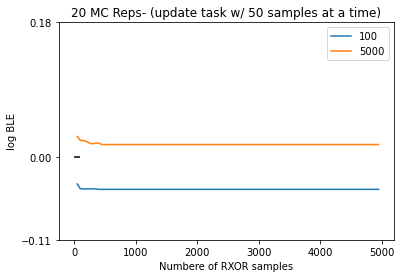

In [58]:
for i,row in enumerate(mean_ble):
    plt.plot(np.arange(0,5000,step=50),np.log(row), label = task1_samples[i])
plt.hlines(0, 0, 90, color = "k")
plt.yticks([-0.11, 0 , 0.18])
plt.xlabel("Numbere of RXOR samples")
plt.ylabel("log BLE")
plt.title("20 MC Reps- (update task w/ 50 samples at a time)")
plt.legend()
#fn.write_result("ble_v_nsamples/20_mc_rep_100_5000_5000_xnor.txt",mean_ble)

In [ ]:
fn.plot_ble_v_nsamples(mean_ble)